<a href="https://colab.research.google.com/github/hughesymendes/TIC-27491137/blob/combining_dips/AllDips.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install lightkurve

!pip install exoplanet

!pip install pymc3==3.8

!pip install corner

/usr/local/lib/python3.6/dist-packages/lightkurve/search.py:233: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


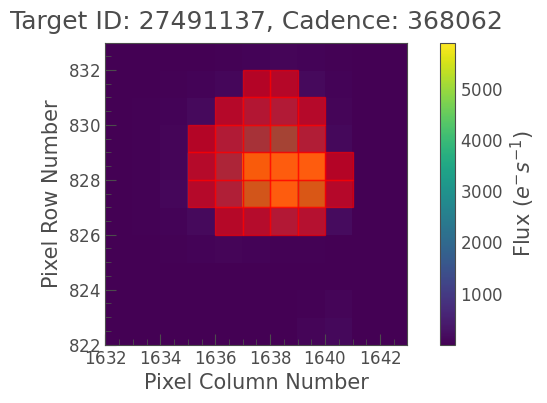

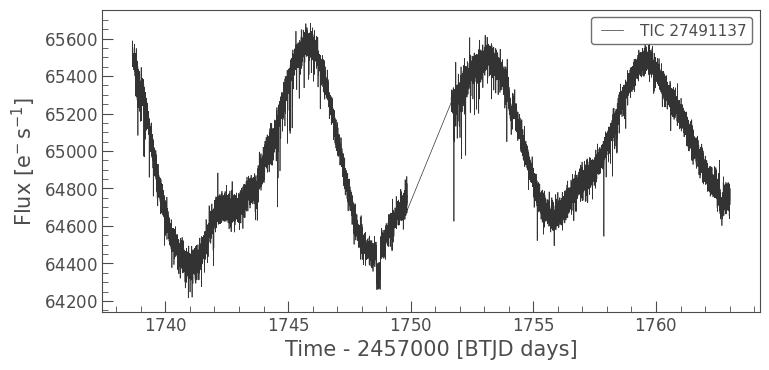

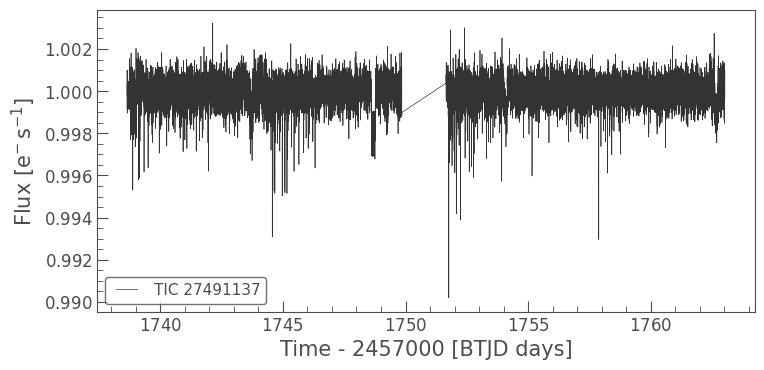

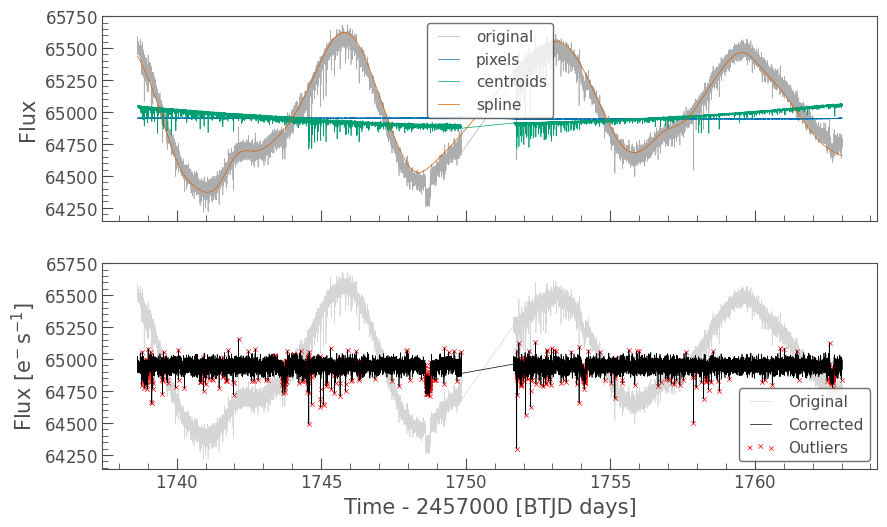

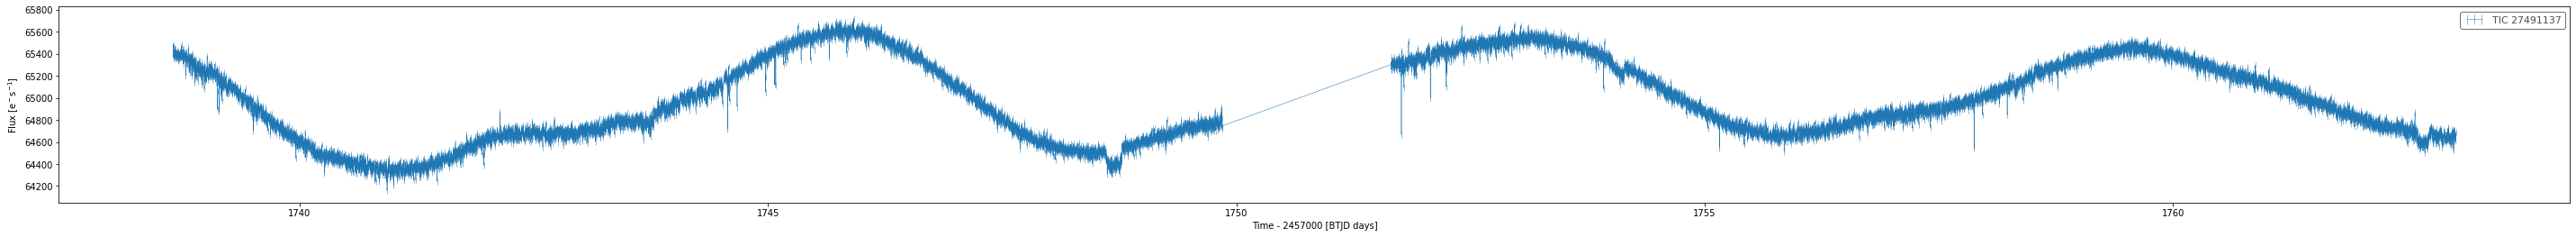

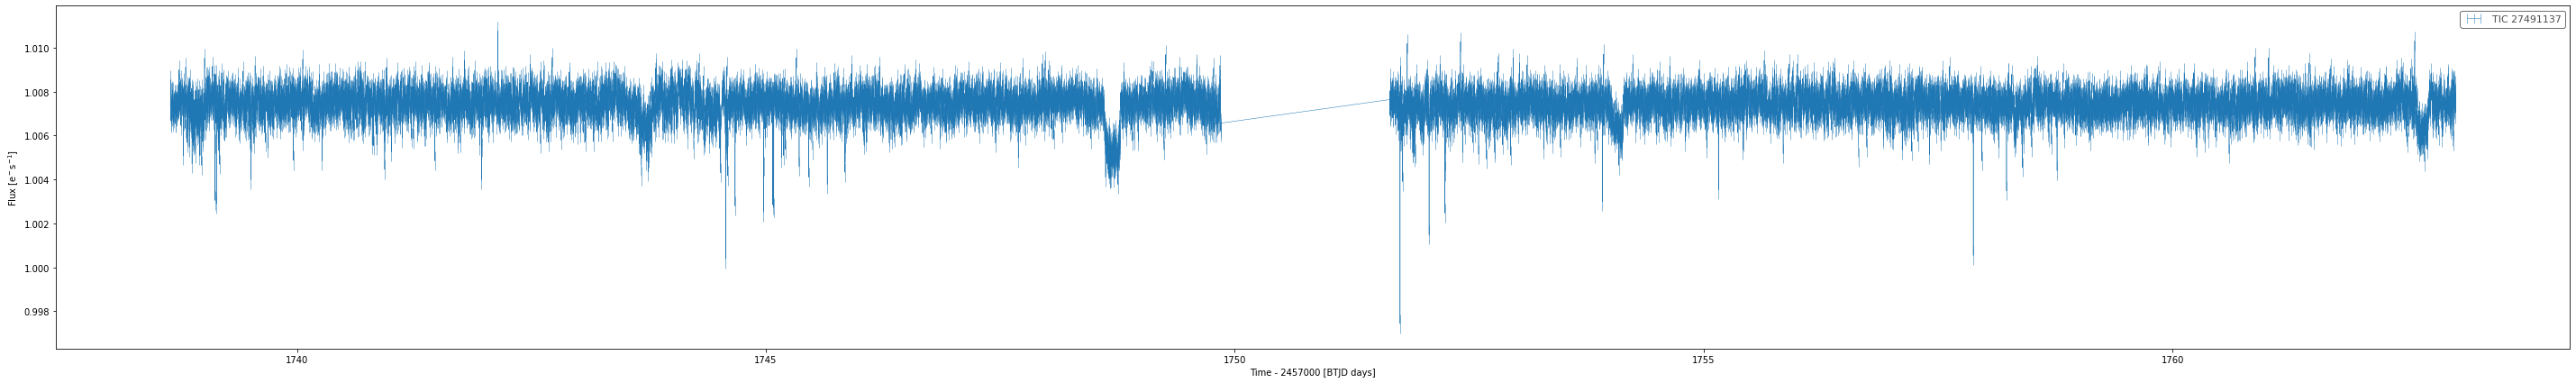

In [5]:
import lightkurve as lk
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#downloading data from MAST
tpf = search_targetpixelfile("TIC 27491137").download()
aper = tpf.create_threshold_mask()
tpf.plot(aperture_mask = aper, mask_color = "red")

#Creating Lightcurve from TPF
lc = tpf.to_lightcurve()

#Masking out Argabrightening events
mask = np.isfinite(lc.flux_err)
clipped = lc[mask]

clipped.plot()

flc = clipped.flatten(window_length = 1001).plot()

pixels = tpf.flux[mask][:, ~aper]
dm1 = lk.DesignMatrix(pixels, name='pixels').pca(3).append_constant()

# We'll do a 3D low order polynomial in TIME, COLUMN CENTROID and ROW CENTROID:

r, c = tpf[mask].estimate_centroids()
r, c = r - np.median(r), c - np.median(c)


t = (lc[mask].cadenceno - np.median(lc.cadenceno))/(len(lc.time))


dm2 = lk.DesignMatrix(np.vstack([r, c, r*c, r**2, c**2, r**2*c, c**2*r, r**2*c**2,
                                t*r, t*c, t*r*c, t*r**2, t*c**2, t*r**2*c, t*c**2*r, t*r**2*c**2]).T, name='centroids')

spline = lk.designmatrix.create_spline_matrix(lc[mask].time, n_knots=35)

dm = lk.DesignMatrixCollection([dm1, dm2, spline])

# Make a very hacky cadence mask:
b = lc[mask].flatten(1001).bin(10)
_, m = b.remove_outliers(3, return_mask=True)
cadence_mask = np.interp(lc[mask].time, b.time, m) != 0

#Tried to make a mask by adding all the areas that i wanted to mask, however it errored out saying needed to be 2D?
#mask = (clipped[3300:3900], clipped[7100:7350], clipped[9500:10000], clipped[15700:]) = True

r = lk.RegressionCorrector(lc[mask])
r.correct(dm, sigma=3., cadence_mask=~cadence_mask)

r.diagnose()

# Remove INSTRUMENT systematics
corr = (r.diagnostic_lightcurves['pixels'] + r.diagnostic_lightcurves['centroids']).flux
corr -= np.median(corr)
clc = (lc[mask] - corr)

fig, ax = plt.subplots(figsize=(50, 4))
(clc).errorbar(ls='-', ax=ax)

# Divide through by STELLAR flux
stellar_flux = r.diagnostic_lightcurves['spline'].flux + np.median(clc.flux)

fig, ax = plt.subplots(figsize=(50, 7))
(clc/stellar_flux).errorbar(ls='-', ax=ax)

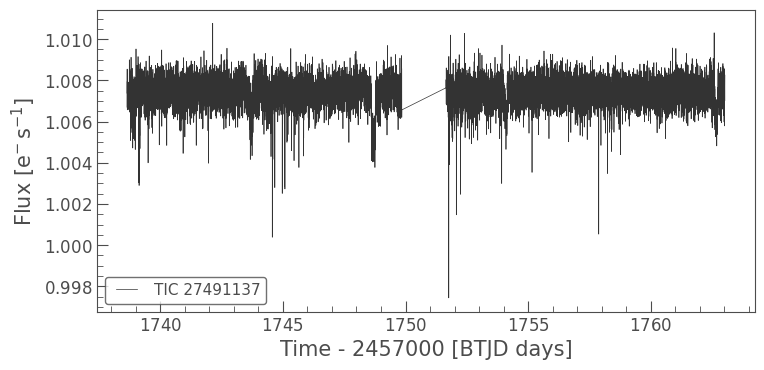

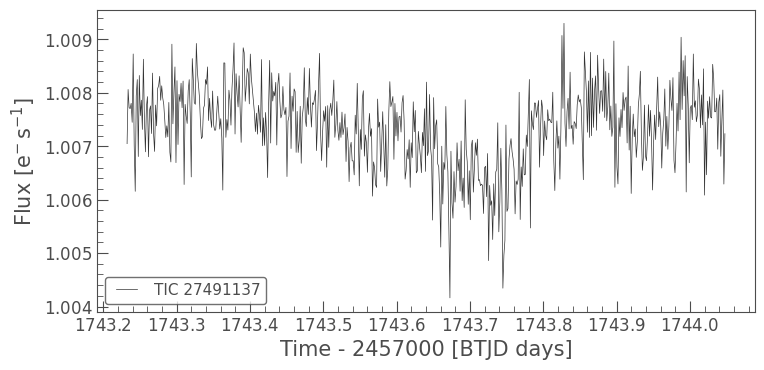

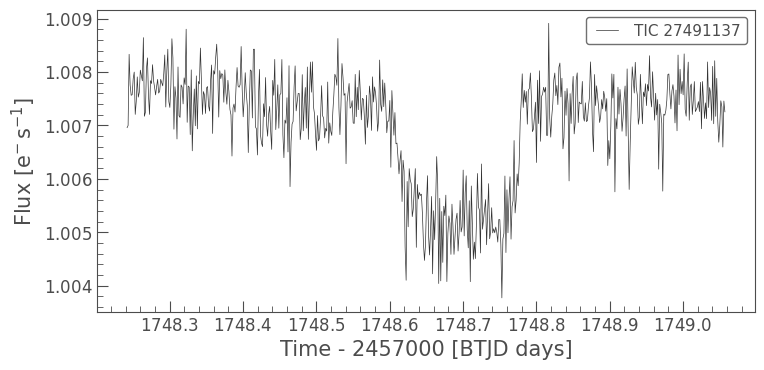

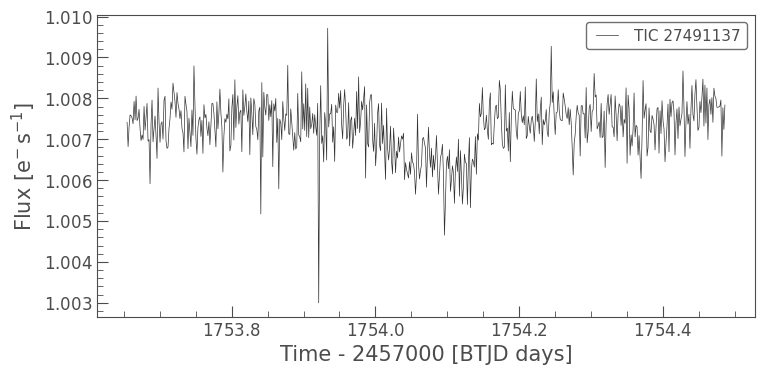

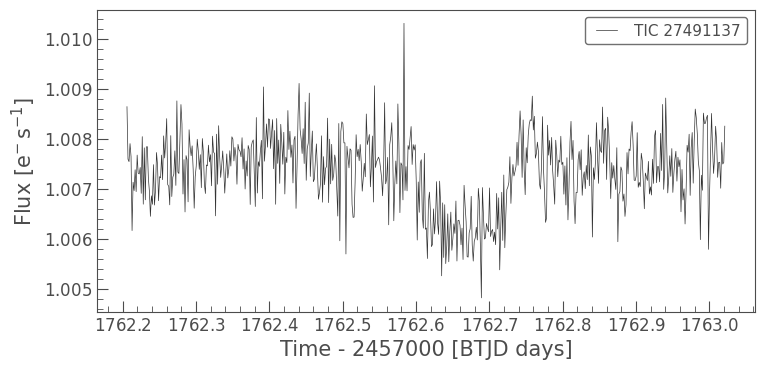

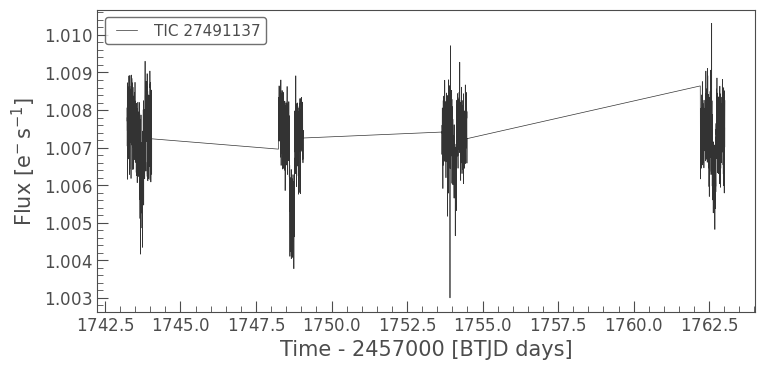

In [6]:
clean_lc = (clc/stellar_flux)
clean_lc.plot()


#IMPORTANT THAT THE ARRAY SIZES FOR THE BELOW DIPS AREN'T CHANGED AS IT WILL AFFECT THE ACCURACY
#OF THE FULL MASKED LC AT THE BOTTOM OF THE CELL. ANY CHANGES IN INDIVIDUAL DIP ARRAY SIZE NEEDS TO BE 
#REFLECTED IN THE MASKING OF THE "AllDips" LC. 



#DIP 1
dip1 = clean_lc[3300:3888]
dip1.plot()

d1x = np.append( np.array( [], dtype="float64" ),dip1.time )
d1y = np.append( np.array( [], dtype="float64" ), dip1.flux - 1.0075 )
d1y_err = np.append( np.array( [], dtype="float64" ), dip1.flux_err )

#DIP 2
dip2 = clean_lc[6900:7488]
dip2.plot()

d2x = np.append( np.array( [], dtype="float64" ),dip2.time )
d2y = np.append( np.array( [], dtype="float64" ), dip2.flux - 1.0075 )
d2y_err = np.append( np.array( [], dtype="float64" ), dip2.flux_err )

#DIP 3
dip3 = clean_lc[9500:10100]
dip3.plot()

d3x = np.append( np.array( [], dtype="float64" ),dip3.time )
d3y = np.append( np.array( [], dtype="float64" ), dip3.flux - 1.0075 )
d3y_err = np.append( np.array( [], dtype="float64" ), dip3.flux_err )

#DIP 4
dip4 = clean_lc[15650:]
dip4.plot()

d4x = np.append( np.array( [], dtype="float64" ),dip4.time )
d4y = np.append( np.array( [], dtype="float64" ), dip4.flux - 1.0075 )
d4y_err = np.append( np.array( [], dtype="float64" ), dip4.flux_err )


#CREATING A MASKED LC SHOWING JUST THE TRANSITS ABOVE
mask1 = (clean_lc.time < 1738.64923721) | (clean_lc.time > 1743.23244862) 
m1lc = clean_lc[mask1]
mask2 = (m1lc.time < 1744.04770813) | (m1lc.time > 1748.24207156) 
m2lc =  m1lc[mask2]
mask3 = (m2lc.time < 1749.0573360) | (m2lc.time > 1753.65447995) 
m3lc = m2lc[mask3]
mask4 = (m3lc.time < 1754.48641353) | (m3lc.time > 1762.20580501) 
AllDips = m3lc[mask4]
AllDips.plot()

ADx = np.append( np.array( [], dtype="float64" ),AllDips.time )
ADy = np.append( np.array( [], dtype="float64" ), AllDips.flux - 1.0075 )
ADy_err = np.append( np.array( [], dtype="float64" ), AllDips.flux_err )

In [25]:
d1x,d2x,d3x,d4x

(array([1743.23244863, 1743.23383749, 1743.23522634, 1743.2366152 ,
        1743.23800406, 1743.23939291, 1743.24078177, 1743.24217063,
        1743.24355948, 1743.24494834, 1743.2463372 , 1743.24772606,
        1743.24911491, 1743.25050377, 1743.25189263, 1743.25328148,
        1743.25467034, 1743.2560592 , 1743.25744805, 1743.25883691,
        1743.26022577, 1743.26161463, 1743.26300348, 1743.26439234,
        1743.2657812 , 1743.26717005, 1743.26855891, 1743.26994777,
        1743.27133663, 1743.27272548, 1743.27411434, 1743.2755032 ,
        1743.27689205, 1743.27828091, 1743.27966977, 1743.28105863,
        1743.28244748, 1743.28383634, 1743.2852252 , 1743.28661405,
        1743.28800291, 1743.28939177, 1743.29078062, 1743.29216948,
        1743.29355834, 1743.2949472 , 1743.29633605, 1743.29772491,
        1743.29911377, 1743.30050262, 1743.30189148, 1743.30328034,
        1743.3046692 , 1743.30605805, 1743.30744691, 1743.30883577,
        1743.31022462, 1743.31161348, 1743.31300

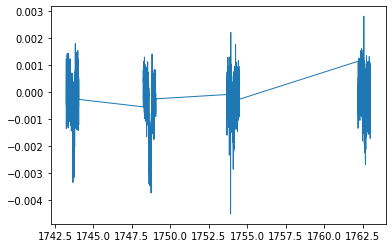

In [14]:
plt.plot(ADx, ADy, color="C0", lw=1)


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [b, r, u, period, logp, t0, mean, radius_p, cot, m_star, cot4, cot3, cot2, cot1, r_star]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 13522.376557123827 -> 14123.035351838944


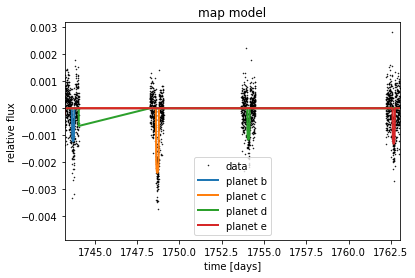

In [61]:
import pymc3 as pm
import exoplanet as xo

with pm.Model() as model:
    #defining vars
    r_star = pm.Normal("r_star", mu=0.772148, sd= 0.0454673,testval= 0.78)
    #each centre of transit
    cot1 = pm.Normal("cot1", mu=1743.72, sd=0.01, testval= 1743.72)
    cot2 = pm.Normal("cot2", mu=1748.69, sd=0.01, testval= 1748.69)
    cot3 = pm.Normal("cot3", mu=1754.075, sd=0.01, testval= 1754.075)
    cot4 = pm.Normal("cot4", mu=1762.67, sd=0.01, testval= 1762.67)
    t0s = np.array([cot1, cot2, cot3, cot4], dtype=object)
    #t0s = np.array([1743.72, 1748.69, 1754.075, 1762.67])

    
    m_star = pm.Normal("m_star", mu=0.87, sd=0.108032, testval= 0.87)
    cot = pm.Normal("cot", mu=1743.72, sd=0.01, testval= 1743.72)
    radius_p = pm.Uniform("radius_p", lower=0.02, upper=0.05, testval=0.03)



    # The baseline flux
    mean = pm.Normal("mean", mu=0, sd=0.0001)

    # The time of a reference transit for each planet
    #t0 = pm.Normal("t0", mu=t0s, sd=0.01, shape=4)
    t0 = pm.Normal("t0", mu=np.array([1743.72, 1748.69, 1754.075, 1762.67]), sd=0.01, shape=4)

    # creating a large uniform distribution for the period
    logP = pm.Uniform("logp", lower=0, upper=2, testval=1, shape = 4)
    period = pm.Uniform("period", lower=0, upper=1000, testval=np.array([15, 20, 10, 10]), shape = 4)
    #period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    #https://arxiv.org/pdf/0912.2274.pdf <-- paper used to estimate values
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.525, 0.215]))

    #r is in units of R_star which is units of R_sun
    #r needs to encompass all possible radii for the 4 transits
    r = radius_p = pm.Uniform("r", lower=0.02, upper=0.05, shape= 4, testval=np.array([0.03, 0.04, 0.03, 0.03]))
    b = xo.distributions.ImpactParameter("b", ror=r/r_star, shape= 4, testval=np.random.rand(4))


    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, r_star=r_star, m_star=m_star)

    # Compute a limb-darkened light curve using starry
    t = ADx

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # The likelihood function assuming known Gaussian uncertainty- 
    #Likelihood function is a function that represents the distribution from an actual test sample
    pm.Normal("obs", mu=light_curve, sd=ADy_err, observed=ADy)

    # Fit for the maximum a posteriori parameters given the simuated dataset
    # Posterior distribution is usually given as Prior*Likelihood
    map_soln = xo.optimize(start=model.test_point)


plt.plot(t, y, ".k", ms=1, label="data")
for i, l in enumerate("bcde"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=2, label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

In [62]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=3000,
        draws=3000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean", "r_star", "m_star"])

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (4 chains in 1 job)
NUTS: [b, r, u, period, logp, t0, mean, radius_p, cot, m_star, cot4, cot3, cot2, cot1, r_star]
Sampling chain 0, 0 divergences:   0%|          | 0/6000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling chain 3, 

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
period[0],523.020,254.797,116.393,992.021,9.776,6.916,679.0,679.0,605.0,507.0,1.01
period[1],34.389,22.553,14.723,79.738,0.709,0.502,1011.0,1011.0,1000.0,2019.0,1.00
period[2],9.533,0.278,9.077,9.969,0.006,0.004,1929.0,1924.0,1897.0,2685.0,1.00
period[3],11.474,1.124,9.748,13.287,0.026,0.018,1896.0,1896.0,1921.0,4840.0,1.00
t0[0],1743.710,0.003,1743.704,1743.716,0.000,0.000,2825.0,2825.0,2822.0,4291.0,1.00
t0[1],1748.694,0.001,1748.692,1748.695,0.000,0.000,3960.0,3960.0,4012.0,5063.0,1.00
t0[2],1754.078,0.001,1754.075,1754.080,0.000,0.000,1660.0,1650.0,1947.0,1351.0,1.00
t0[3],1762.665,0.002,1762.662,1762.668,0.000,0.000,1845.0,1845.0,1933.0,3360.0,1.00
r[0],0.036,0.006,0.027,0.047,0.000,0.000,623.0,615.0,613.0,885.0,1.01
r[1],0.037,0.002,0.033,0.041,0.000,0.000,1232.0,1223.0,1260.0,1990.0,1.00


IndexError: ignored

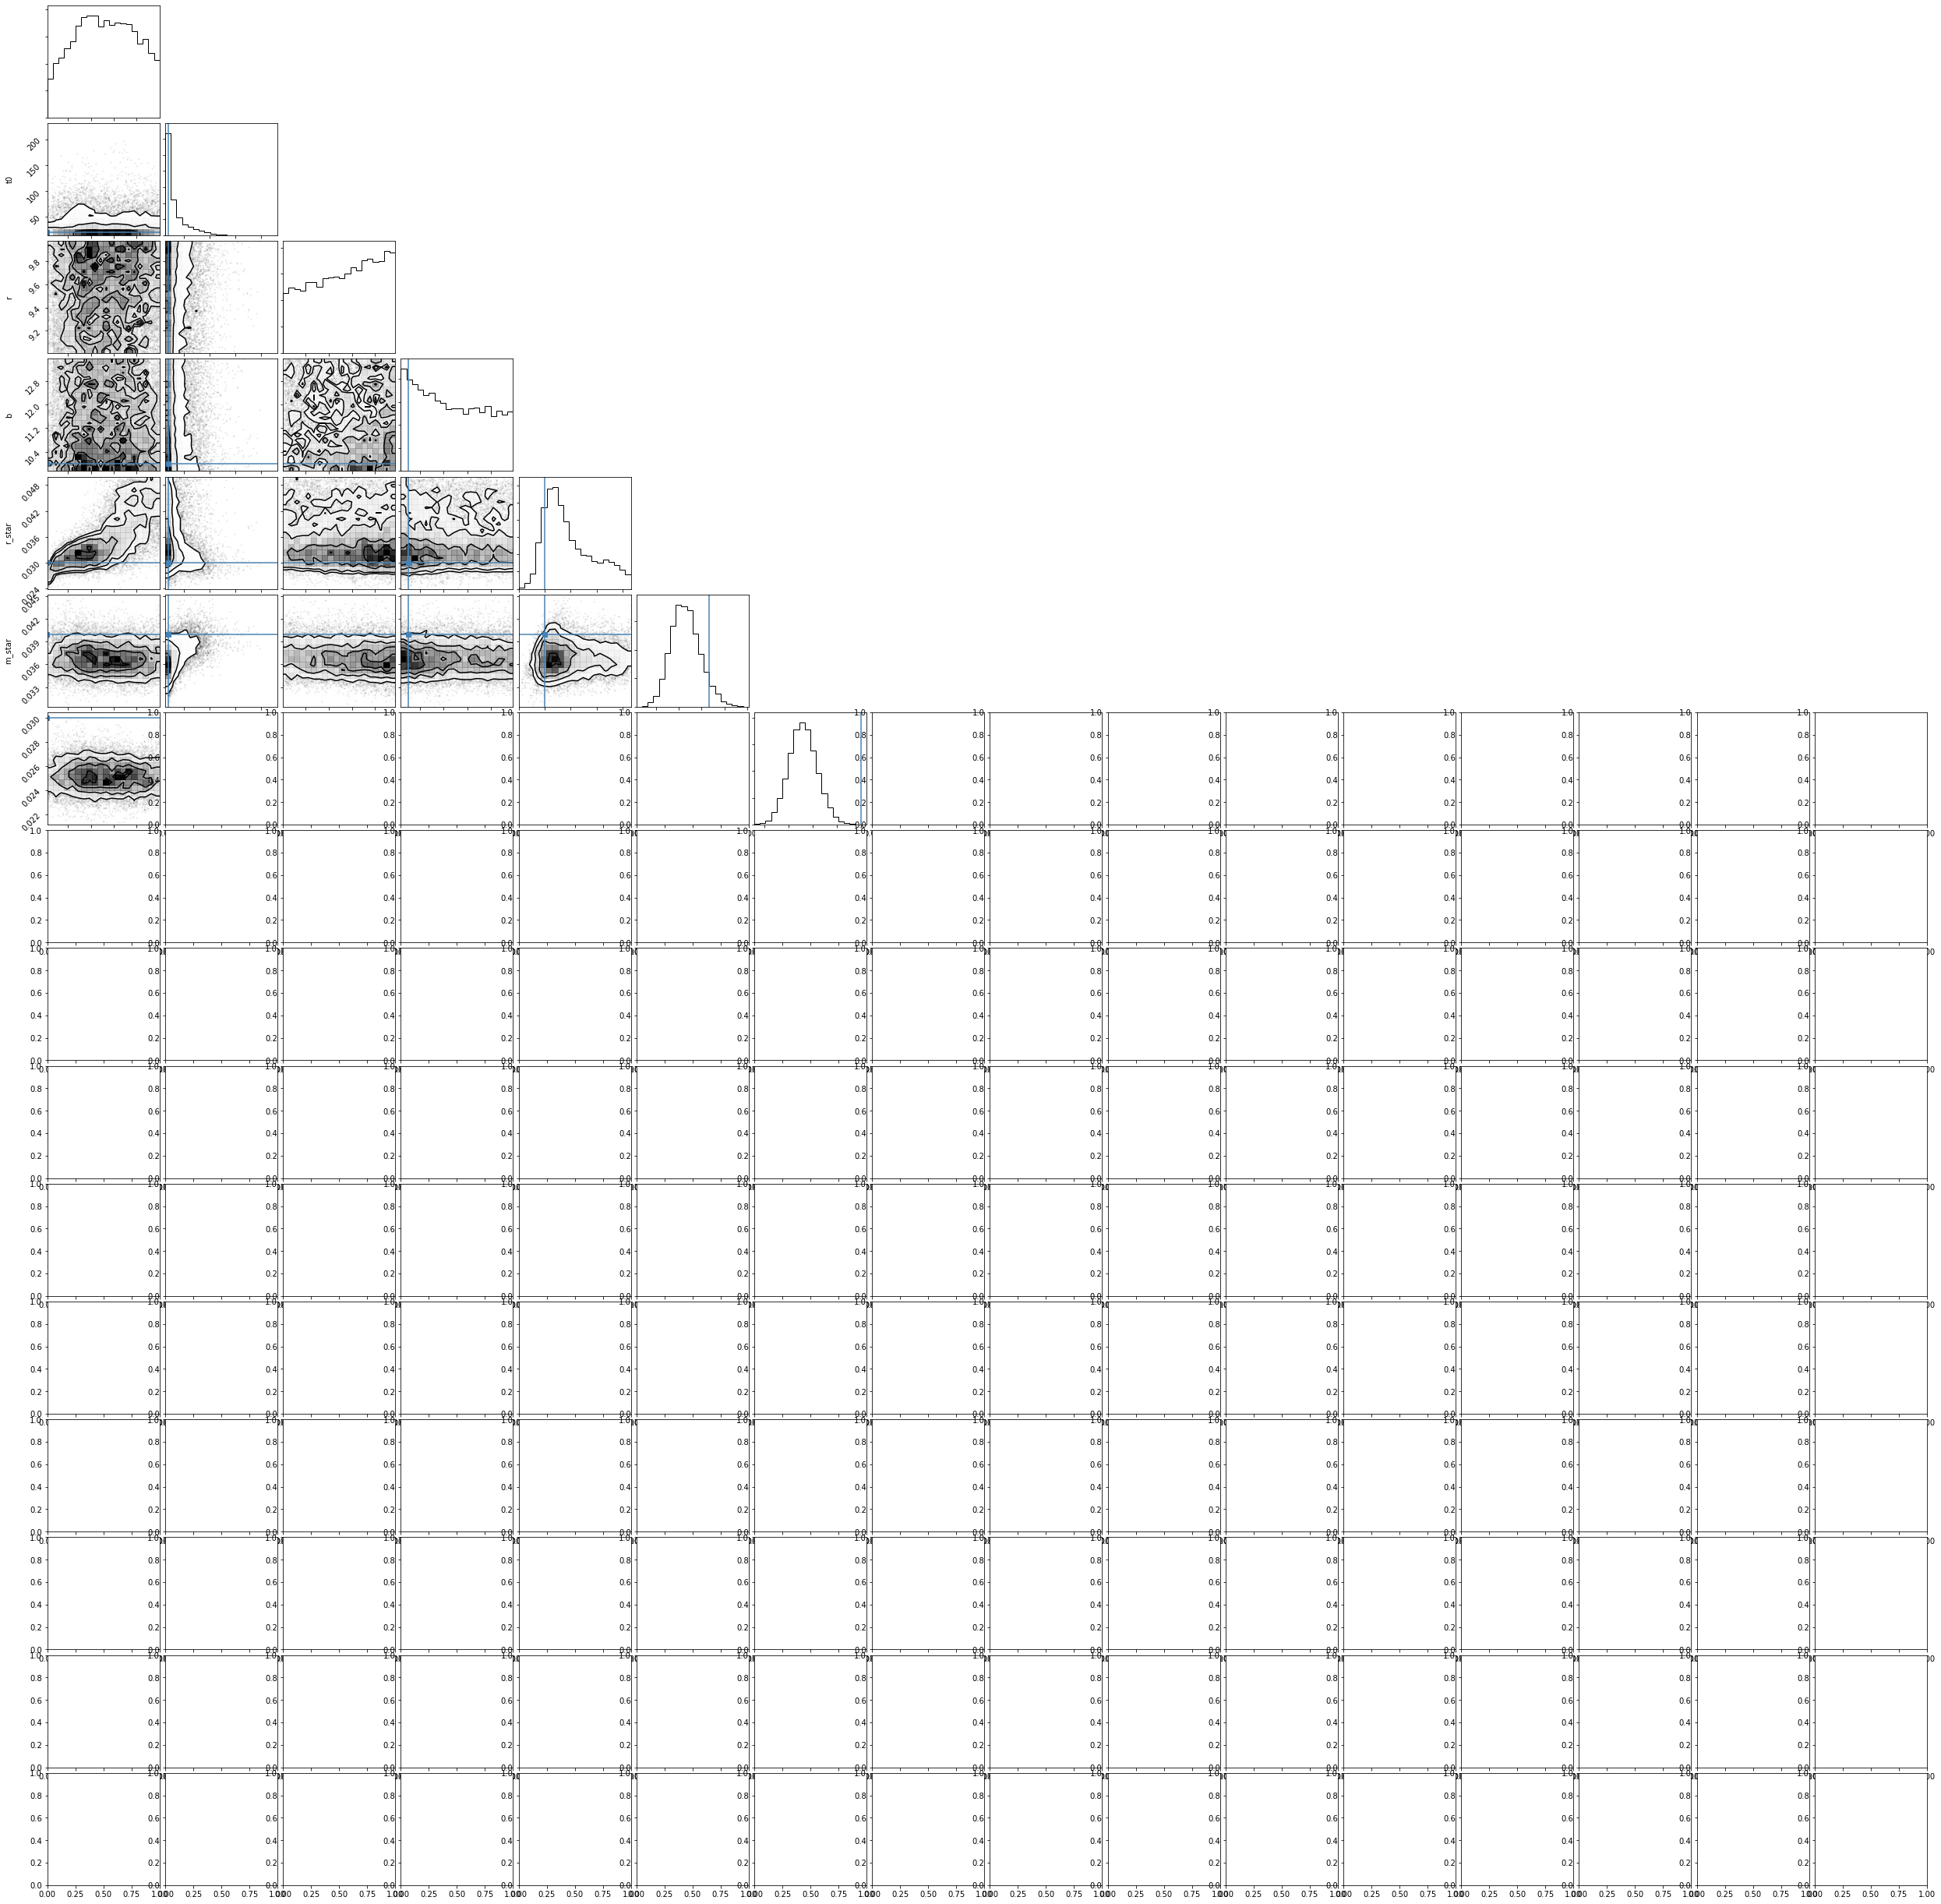

In [65]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["period", "r", "b", "t0"])
truth = np.concatenate(xo.eval_in_model([period, r, b, t0], model.test_point, model=model))
corner.corner(
    samples, truths=truth, labels=["period", "t0", "r", "b", "r_star", "m_star"]
);

In [0]:
import pymc3 as pm
import exoplanet as xo

with pm.Model() as model:
    #defining vars
    r_star = pm.Normal("r_star", mu=0.772148, sd= 0.0454673,testval= 0.78)
    #each centre of transit
    cot1 = pm.Normal("cot1", mu=1743.72, sd=0.01, testval= 1743.72)
    cot2 = pm.Normal("cot2", mu=1748.69, sd=0.01, testval= 1748.69)
    cot3 = pm.Normal("cot3", mu=1754.075, sd=0.01, testval= 1754.075)
    cot4 = pm.Normal("cot4", mu=1762.67, sd=0.01, testval= 1762.67)
    t0s = np.array([cot1, cot2, cot3, cot4], dtype=object)
    #t0s = np.array([1743.72, 1748.69, 1754.075, 1762.67])

    
    mass_s = pm.Normal("m_star", mu=0.87, sd=0.108032, testval= 0.87)
    cot = pm.Normal("cot", mu=1743.72, sd=0.01, testval= 1743.72)
    radius_p = pm.Uniform("radius_p", lower=0.02, upper=0.05, testval=0.03)



    # The baseline flux
    mean = pm.Normal("mean", mu=0, sd=0.0001)

    # The time of a reference transit for each planet
    #t0 = pm.Normal("t0", mu=t0s, sd=0.01, shape=4)
    t0 = pm.Normal("t0", mu=np.array([1743.72, 1748.69, 1754.075, 1762.67]), sd=0.01, shape=4)

    # creating a large uniform distribution for the period
    logP = pm.Uniform("logp", lower=0, upper=2, testval=1, shape = 4)
    period = pm.Uniform("period", lower=0, upper=1000, testval=10, shape = 4)
    #period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    #https://arxiv.org/pdf/0912.2274.pdf <-- paper used to estimate values
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.525, 0.215]))

    #r is in units of R_star which is units of R_sun
    #r needs to encompass all possible radii for the 4 transits
    r = radius_p = pm.Uniform("r", lower=0.02, upper=0.05, shape= 4, testval=np.array([0.03, 0.04, 0.03, 0.03]))
    b = xo.distributions.ImpactParameter("b", ror=r/r_star, shape= 4, testval=np.random.rand(4))


    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, r_star=r_star, m_star=mass_s)

    # Compute a limb-darkened light curve using starry
    t = ADx

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # The likelihood function assuming known Gaussian uncertainty- 
    #Likelihood function is a function that represents the distribution from an actual test sample
    pm.Normal("obs", mu=light_curve, sd=ADy_err, observed=ADy)

    # Fit for the maximum a posteriori parameters given the simuated dataset
    # Posterior distribution is usually given as Prior*Likelihood
    map_soln = xo.optimize(start=model.test_point)


plt.plot(t, y, ".k", ms=1, label="data")
for i, l in enumerate("bcde"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=2, label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")